# Day-ahead price forecasting with machine learning

This is a brief look at the electricity market of Germany, with the specific objective of **forecasting day-ahead and intra-day prices using gradient boosting and deep learning techniques**. The focus is on the exploration of SOTA time-series forecast methods in the machine learning and deep learning literature.

## Brief overview of domain knowledge

Free electricity markets are governed by a strong supply-demand dynamics. The key reason is that electricity can't be stored, so what is generated needs to be used up instantly.$^1$ That said, since industries (and homes alike) rely significantly on a reliable energy supply, fixing specific amounts of consumption and producing that amount does not suffice. Events like generator outage and excessive consumption have to be taken into account, hence the need for reserve supplies.

- futures market: the price is set (upto 6 years) in advance, though you pay a premium for this assurance,
- day-ahead market: the price is set a day before,
- intraday market

In [0]:
# if you are working from outside the repository
!git clone https://github.com/sandeshbhatjr/energy-prediction.git

Cloning into 'energy-prediction'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 1), reused 17 (delta 1), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [0]:
!pip install -U --quiet workalendar astral gluonts entsoe-py

     |████████████████████████████████| 163kB 4.9MB/s 
     |████████████████████████████████| 327kB 15.9MB/s 
     |████████████████████████████████| 256kB 22.1MB/s 
     |████████████████████████████████| 16.0MB 197kB/s 
     |████████████████████████████████| 194kB 59.3MB/s 
     |████████████████████████████████| 7.5MB 21.0MB/s 
     |████████████████████████████████| 235kB 50.8MB/s 
ERROR: gluonts 0.4.2 has requirement python-dateutil==2.8.0, but you'll have python-dateutil 2.6.1 which is incompatible.


Part 1 of **time forecasting with energy**

## Data extraction and understanding

In [0]:
import datetime as dt
from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from urllib.parse import urljoin
from numba import jit

The data at SMARD is given in .csv format and encompasses all the day-ahead prices starting from 2015 until the current date. This is convenient for analysis though for whatever reasons, they only allow us to download in intervals of 2 years, so our data is split amongst three .csv files. This needs to be combined.

In [0]:
root_path = 'energy-prediction/data/Germany/day-ahead-price/'
df1 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201501010000_201701012359_1.csv'), sep=';')
df2 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201701010000_201901012359_1.csv'), sep=';')
df3 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201901010000_202002062359_1.csv'), sep=';')
df = df1.append(df2[df2['Date'] != 'Jan 1, 2017']).append(df3[df3['Date'] != 'Jan 1, 2019'])

Now, to do some typical data type conversion steps to make it easier for selection with pandas.

In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time of day'] = pd.to_datetime(df['Time of day']).dt.time
df.replace('-', 'NaN', inplace=True)
countries = list(filter(lambda x: x.endswith('[Euro/MWh]'), sorted(df)))
for country in countries:
  df[country] = df[country].astype('float')
df['timedate'] = pd.to_datetime(df['Date'].astype('str') + ' ' + df['Time of day'].astype('str'))
df.set_index('timedate', drop=True, inplace=True)
df.index.name = None

df.sample(2)

,Date,Time of day,Germany/Luxembourg[Euro/MWh],Denmark 1[Euro/MWh],Denmark 2[Euro/MWh],France[Euro/MWh],Northern Italy[Euro/MWh],Netherlands[Euro/MWh],Poland[Euro/MWh],Sweden 4[Euro/MWh],Switzerland[Euro/MWh],Slovenia[Euro/MWh],Czech Republic[Euro/MWh],Hungary[Euro/MWh],Austria[Euro/MWh],Germany/Austria/Luxembourg[Euro/MWh]
2017-12-16 06:00:00,2017-12-16,06:00:00,NaN,30.20,30.20,44.84,NaN,39.50,NaN,30.20,56.11,31.58,29.9,29.9,NaN,31.58
2017-09-29 21:00:00,2017-09-29,21:00:00,NaN,29.21,32.21,49.66,55.0,38.19,NaN,29.21,48.98,32.21,36.5,36.5,NaN,32.21


**Some data cleaning** is in order; there should be 24 day-ahead prices for each hour of every day. Let's see if our data matches this requirement.

In [0]:
stat_frame = df.groupby('Date', as_index=False).count()
stat_frame[stat_frame['Time of day'] != 24].loc[:, ['Date', 'Time of day']]

,Date,Time of day
87,2015-03-29,23
297,2015-10-25,25
451,2016-03-27,23
668,2016-10-30,25
815,2017-03-26,23
1032,2017-10-29,25
1179,2018-03-25,23
1396,2018-10-28,25
1550,2019-03-31,23
1760,2019-10-27,25


**It doesn't**. If you think about it for a bit, you will realise that the above list of dates correpond to when the time changes because of **Daylight savings time**, so the missing entry is because of the hour skipped due to the change in time. I will tackle this by shifting back the daylight savings time (by one hour) to normal time, and then marking the change in a separate column to account for possible change in schedule due to shifted work hours.

In [0]:
daylight_savings_ranges = [
  (dt.datetime(2015,3,29,3,0,0), dt.datetime(2015,10,25,2,0,0)),
  (dt.datetime(2016,3,27,3,0,0), dt.datetime(2016,10,30,2,0,0)),
  (dt.datetime(2017,3,26,3,0,0), dt.datetime(2017,10,29,2,0,0)),
  (dt.datetime(2018,3,25,3,0,0), dt.datetime(2018,10,28,2,0,0)),
  (dt.datetime(2019,3,31,3,0,0), dt.datetime(2019,10,27,2,0,0))
]

change_dict = {}
for d1, d2 in daylight_savings_ranges:
  previous_index = (df.loc[d1:d2, 'Time of day'].index)
  modified_index = previous_index - pd.to_timedelta(1, unit='h')
  change_dict.update(zip(previous_index, modified_index))

corrected_df = df.rename(index=change_dict)
corrected_df.loc[dt.datetime(2015,10,25,1,0,0)]
new_index = corrected_df.index \
  .where(~corrected_df.index.duplicated(), corrected_df.index + pd.to_timedelta(1, unit='h'))
corrected_df.set_index(new_index, inplace=True)
corrected_df['Time of day'] = corrected_df.index.time
corrected_df['Date'] = pd.to_datetime(corrected_df.index.date)

# add a column to indicate this change
corrected_df['Daylight Savings Time'] = 0
corrected_df.loc[change_dict.values(), 'Daylight Savings Time'] = 1

Bdf = corrected_df.groupby('Date', as_index=False).count()
assert len(Bdf[Bdf['Time of day'] != 24]) == 0

We are interested in the german electricity market, so we can just extract the prices for that specific column. But a look at the data reveals that there are two columns with Germany in them: `Germany/Luxembourg[Euro/MWh]` and `Germany/Austria/Luxembourg[Euro/MWh]`. This is because until October 2018- Germany, Austria and Luxembourg used to be in the same bidding zone, but this was changed to relieve congestion between the two countries, by splitting Austria into a separate zone.$^{[3]}$ We will combine both these datapoints into one single dataset consisting of day-ahead prices from 2015 until now, though we will use a separate column to indicate the bidding zone.

In [0]:
# the following should be empty for consistency
c1 = corrected_df['Germany/Luxembourg[Euro/MWh]'].notnull()
c2 = corrected_df['Germany/Austria/Luxembourg[Euro/MWh]'].notnull()
(c1 & c2).value_counts()

False    44712
dtype: int64

In [0]:
pre_2018_german_df = \
corrected_df[['Date', 'Time of day', 'Daylight Savings Time', 'Germany/Austria/Luxembourg[Euro/MWh]']] \
[:dt.datetime(2018,9,30,22,0,0)] \
.copy() \
.rename(columns={'Germany/Austria/Luxembourg[Euro/MWh]': 'Day Ahead Price'})
pre_2018_german_df['Bidding Zone'] = 'DE-AT-LU'

post_2018_german_df = \
corrected_df[['Date', 'Time of day', 'Daylight Savings Time', 'Germany/Luxembourg[Euro/MWh]']] \
[dt.datetime(2018,9,30,23,0,0):] \
.copy() \
.rename(columns={'Germany/Luxembourg[Euro/MWh]': 'Day Ahead Price'})
post_2018_german_df['Bidding Zone'] = 'DE-LU'

german_df = pre_2018_german_df.append(post_2018_german_df)

german_df.sample(5)

,Date,Time of day,Daylight Savings Time,Day Ahead Price,Bidding Zone
2016-10-14 10:00:00,2016-10-14,10:00:00,1,29.55,DE-AT-LU
2018-08-21 02:00:00,2018-08-21,02:00:00,1,50.27,DE-AT-LU
2016-06-16 09:00:00,2016-06-16,09:00:00,1,34.88,DE-AT-LU
2019-11-03 19:00:00,2019-11-03,19:00:00,0,41.04,DE-LU
2019-03-12 22:00:00,2019-03-12,22:00:00,0,23.87,DE-LU


There will be some algorithms further up which handle missing values badly, so let's see if there are missing values.

In [0]:
german_df['Date'][german_df['Day Ahead Price'].isnull()].unique()

array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', '2015-01-04T00:00:00.000000000',
       '2015-01-05T00:00:00.000000000', '2019-07-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-09-02T00:00:00.000000000',
       '2019-09-03T00:00:00.000000000', '2020-01-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

Those aren't too many values: we can omit entries from 1st-5th of Jan, 2015, as they are in the beginning of the dataset. As for the rest, we will take the mean values of the neighbouring entries to fill them up.

In [0]:
# drop the first few
indices_to_drop = german_df[dt.datetime(2015,1,1,0,0,0):dt.datetime(2015,1,5,23,0,0)].index
german_df.drop(indices_to_drop, inplace=True)

# replace the rest
german_df.loc[dt.datetime(2019,9,2,23,0,0), 'Day Ahead Price'] = \
  (german_df.loc[dt.datetime(2019,9,1,23,0,0), 'Day Ahead Price'] + \
   german_df.loc[dt.datetime(2019,9,3,23,0,0), 'Day Ahead Price'])/2
german_df.loc[dt.datetime(2019,7,30,23,0,0), 'Day Ahead Price'] = \
  (german_df.loc[dt.datetime(2019,7,29,23,0,0), 'Day Ahead Price'] + \
   german_df.loc[dt.datetime(2019,7,31,23,0,0), 'Day Ahead Price'])/2
for i in range(23):
  german_df.loc[dt.datetime(2019,9,3,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2019,9,2,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2019,9,4,i,0,0), 'Day Ahead Price'])/2
  german_df.loc[dt.datetime(2019,7,31,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2019,7,30,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2019,8,1,i,0,0), 'Day Ahead Price'])/2
for i in range(24):
  german_df.loc[dt.datetime(2020,1,31,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2020,1,30,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2020,2,1,i,0,0), 'Day Ahead Price'])/2

# check
german_df['Date'][german_df['Day Ahead Price'].isnull()].unique()

array([], dtype='datetime64[ns]')

There! The first level of data cleaning and preparation is done. We can proceed to analyse and explore our dataset.

### Seasonality

In [0]:
german_df['Hour'] = german_df['Time of day'].apply(lambda x: x.hour)
german_df['Day of Week'] = german_df['Date'].dt.weekday
german_df['Day'] = german_df['Date'].apply(lambda x: x.day)
german_df['Month'] = german_df['Date'].apply(lambda x: x.month)
german_df['Year'] = german_df['Date'].apply(lambda x: x.year)

#### Daily patterns

There must be some daily patterns in the prices, cause the consumption- I am guessing- has similar patterns everyday especially on a regular workday. This obviously changes when it is a weekend, or a holiday, so lets see what the data has to say about daily patterns.

First up, let us look at an aggregrated data of prices grouped by time of day. We want to see mean usage over the day, and how much this varies across different dates. A box plot is well suited for this.

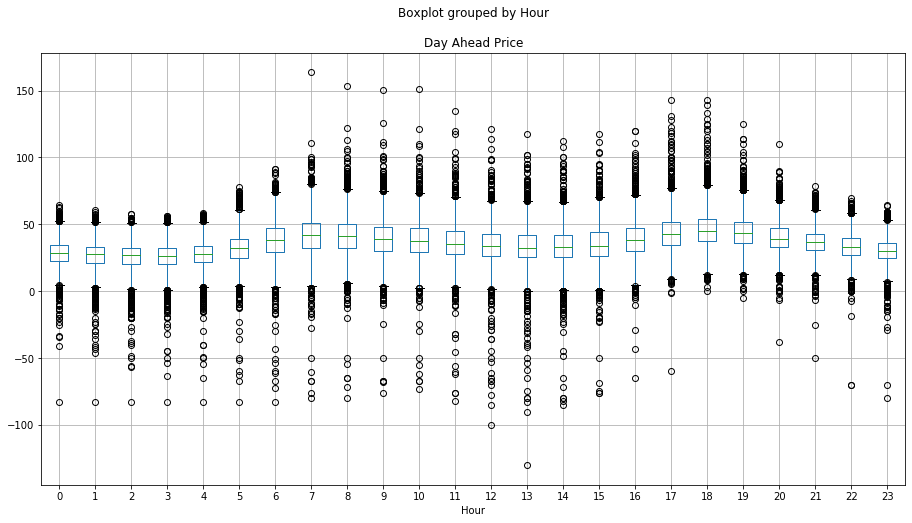

In [0]:
german_df.boxplot(column=['Day Ahead Price'], by='Hour', figsize=(15,8))

Seems like it has twin peaks of usage: typically around 8:00 and 19:00 each day. Sounds perfectly reasonable. Further, the variance in prices is more during 6:00 to 20:00, and lesser during the rest, especially the spikes in prices.

> Why are there negative values? Do they really pay to give away electricity in these intervals?

In [0]:
def plotDailyAheadPrice(date, color, axes, opacity=1):
  german_df['Hour'] = german_df['Hour'].astype('float')
  german_df[['Hour', 'Day Ahead Price']][german_df['Date'] == date] \
  .plot.line(
      'Hour', 'Day Ahead Price', 
       figsize=(15, 10), 
       color=color, 
       ax=axes, 
       legend=False,
       linestyle='--', 
       marker='o',
       alpha=opacity
  )

def quantilePlots(german_df, number_of_levels, opacity_threshold, color='grey'):
  """
    Prepare a plotted figure with the quantiles plotted as contours,
    as a reference for plotting further daily plots
  """
  grouped_by_hour = german_df[['Hour', 'Day Ahead Price']] \
  .groupby('Hour', as_index=False)

  # calculate mean by hour
  stat_df = grouped_by_hour.mean().copy()
  stat_df.rename(columns={'Day Ahead Price': 'mean'}, 
                 inplace=True)
  
  # calculate quantiles by hour
  for i in range(2*number_of_levels + 1):
    stat_df['q{}'.format(i)] = grouped_by_hour \
    .quantile(i / (2*number_of_levels)) \
    .loc[:, 'Day Ahead Price']

  # prepare matplot objects for plotting
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

  # plot quantile contours
  for i in range(number_of_levels):
    j = 2*number_of_levels - i
    alpha_level = opacity_threshold*((i+1)/(2*number_of_levels))
    plt.fill_between(
      stat_df['Hour'], stat_df['q{}'.format(i)], stat_df['q{}'.format(j)], 
      color=color, alpha=alpha_level
    )
    plt.plot(stat_df['Hour'], stat_df['q{}'.format(i)], color=color, alpha=0.1)
    plt.plot(stat_df['Hour'], stat_df['q{}'.format(j)], color=color, alpha=0.1)
  
  # plot mean
  plt.plot(stat_df['Hour'], stat_df['q{}'.format(number_of_levels)], 
           color=color, 
           linewidth=3,
           alpha=opacity_threshold)

  return axes

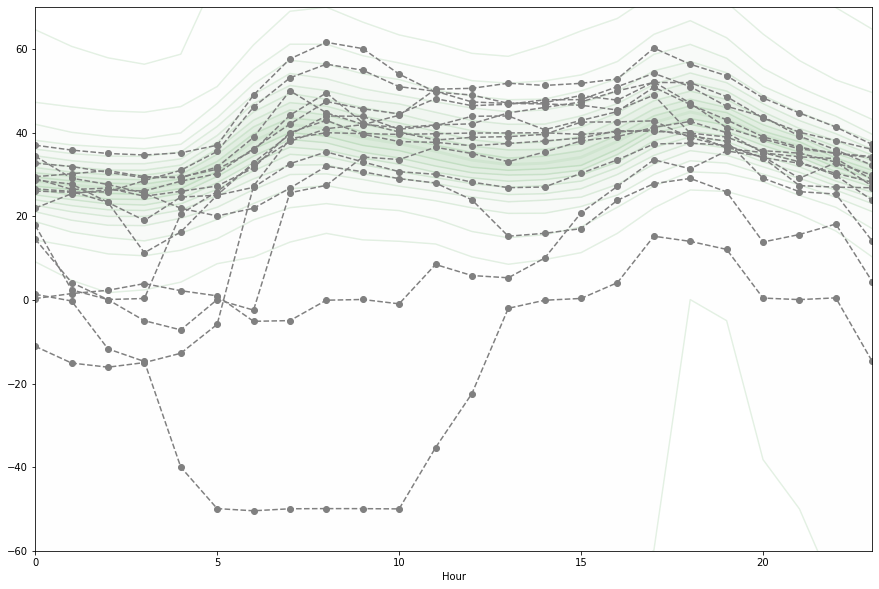

In [0]:
def dateRange(startDate, endDate):
  currentDate = startDate
  while (endDate > currentDate):
    currentDate = currentDate + dt.timedelta(days=1)
    yield currentDate

axes2 = quantilePlots(german_df, 10, 0.05, color='green')
plt.ylim(top=70, bottom=-60)

starting = dt.datetime(2019, 12, 6)
until = dt.datetime(2019, 12, 20)
for date in dateRange(starting, until):
  plotDailyAheadPrice(date, 'grey', axes2)

In [0]:
weekly_df = german_df.groupby(['Day of Week', 'Hour'], as_index=False).mean()

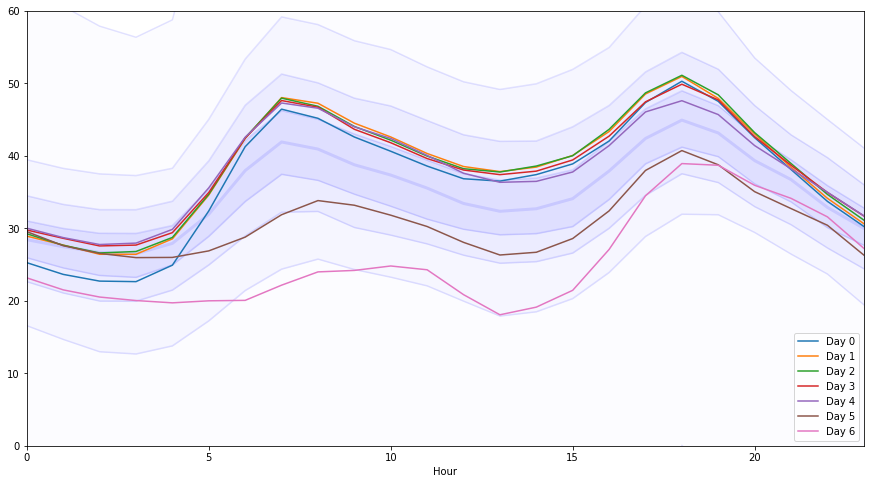

In [0]:
axes = quantilePlots(german_df, 4, 0.1, 'blue')
plt.ylim(top=60, bottom=0)
for day in range(7):
  weekly_df[weekly_df['Day of Week'] == day] \
  .rename(columns={'Day Ahead Price' : 'Day ' + str(day)}) \
  .plot.line('Hour', 'Day ' + str(day), ax=axes)

#### Weekly patterns

Sundays and Saturdays are off; does that lead to a change in pattern for those days?

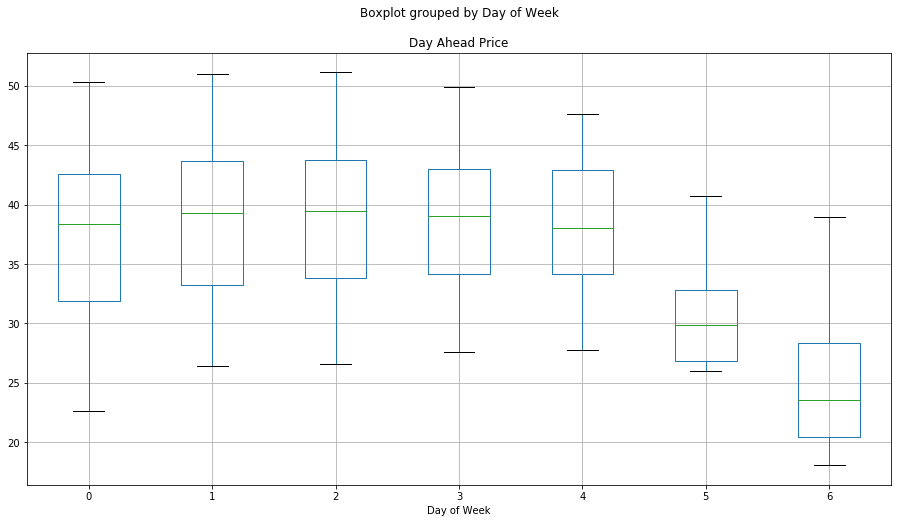

In [0]:
weekly_df.boxplot(column=['Day Ahead Price'], by='Day of Week', figsize=(15,8))

#### Monthly patterns

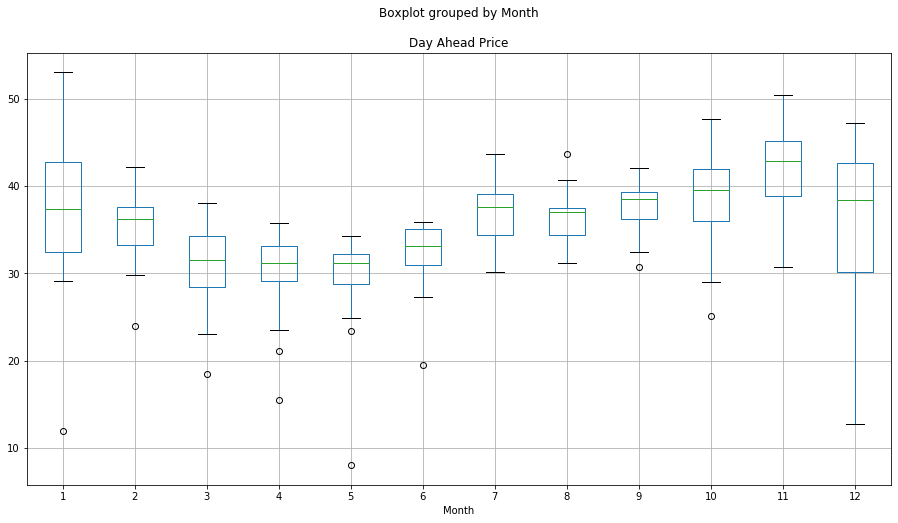

In [0]:
german_df.groupby(['Day', 'Month'], as_index=False).mean() \
  .boxplot(column=['Day Ahead Price'], by='Month', figsize=(15,8))

#### Annual patterns

Seasonality (by which I literally mean the seasons such as winter, summer and so on) influence energy consumption and generation.

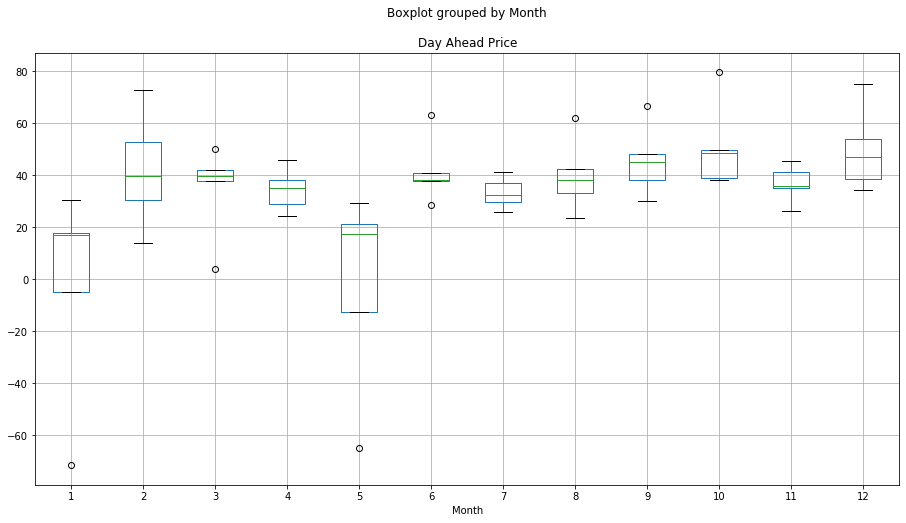

In [0]:
german_df[(german_df['Hour'] == 8) & (german_df['Day'] == 1)] \
.boxplot(column=['Day Ahead Price'], by='Month', figsize=(15,8))

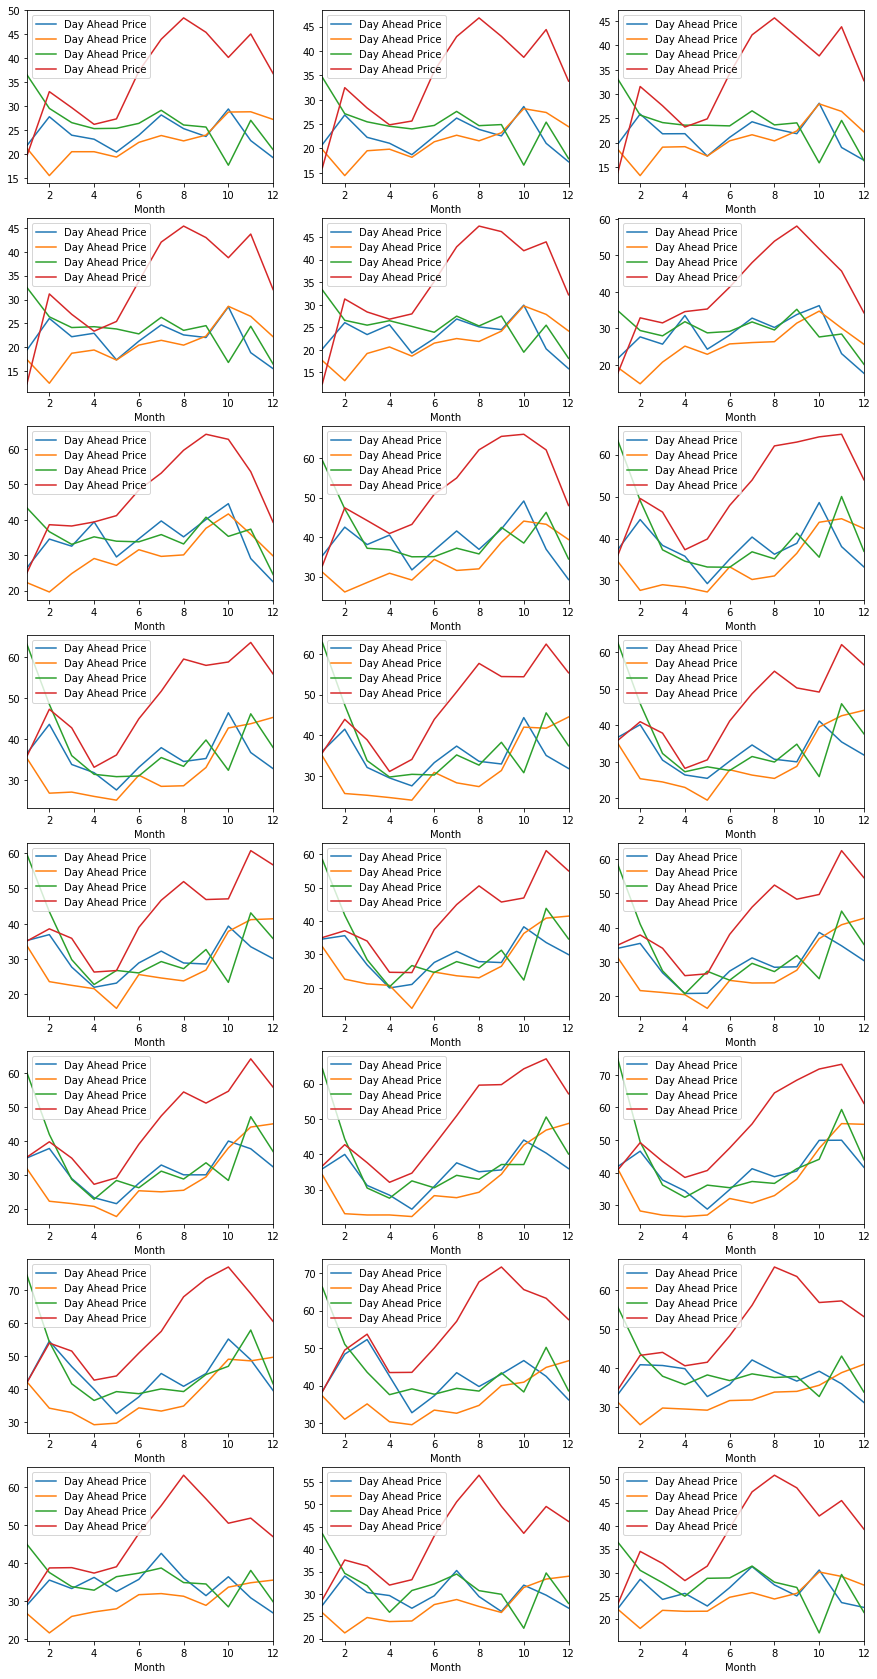

In [0]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(15,30))

for h in range(24):
  german_df_monthly = german_df[german_df['Hour'] == h].groupby(['Month', 'Year'], as_index=False).mean()
  for y in range(2015, 2019):
    german_df_monthly[german_df_monthly['Year'] == y].plot('Month', 'Day Ahead Price', ax=axes[h//3,h%3])

### Holidays and other predictable spikes

**Holidays** are slightly more complicated than just being a seasonal pattern. Some holidays are based on the lunar calendar, while some change (like Easter) from year to year based on other conditions. But whether a day is a holiday or not affects demand, so it is useful to include this feature in our analysis. A quick search reveals python packages called `Holidays` and `Workalendar`; I would prefer to implement my own version, but due to time constraints, I have chosen `Workalendar`.

In [0]:
from workalendar.registry import registry
from collections import defaultdict

from_year = 2014
to_year = 2020

# our bidding zone consists of Austria (pre-2018), Germany and Luxembourg
calendars = registry.get_calendars(['AT', 'DE', 'LU'], include_subregions=True)
holidayDict = defaultdict(list)
countrySet = set()
for country, calendar in calendars.items():
  countrySet.add(country)
  temp_obj = calendar()
  for year in range(from_year, to_year):
    for holidayDate, holidayName in temp_obj.holidays(year):
      holidayDict[holidayDate].append((holidayName, country))

def get_holiday(chosenDate, region):
  holidays_on_date = holidayDict[chosenDate]
  for holiday, region_of_holiday in holidays_on_date:
    if region_of_holiday == region:
      return holiday
  return 'normal day'

for country in countrySet:
  german_df[country] = german_df['Date'].apply(lambda x: get_holiday(x.date(), country))

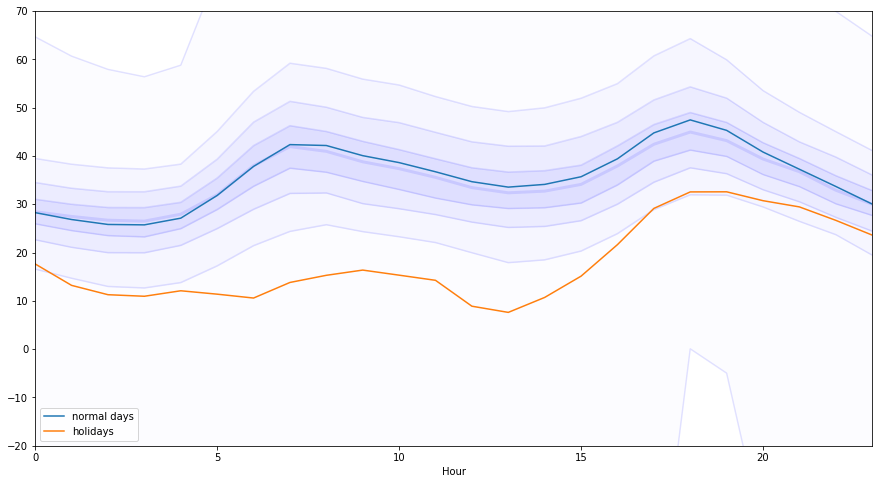

In [0]:
axes = quantilePlots(german_df, 4, 0.1, 'blue')

plt.ylim(top=70, bottom=-20)

german_df[german_df['DE'] == 'normal day'] \
  .groupby('Hour', as_index=False) \
  .mean() \
  .rename(columns={'Day Ahead Price' : 'normal days'}) \
  .plot('Hour', 'normal days', ax=axes)

german_df[german_df['DE'] != 'normal day'] \
  .groupby('Hour', as_index=False) \
  .mean() \
  .rename(columns={'Day Ahead Price' : 'holidays'}) \
  .plot('Hour', 'holidays', ax=axes)

### Sunrise and sunset

Does daylight affect electricity consumption?

In [0]:
from astral import LocationInfo
from astral.sun import sun

city = LocationInfo("Berlin", "Germany", "Europe/Berlin", 52.5, 13.40)
s = sun(city.observer, date=dt.date(2020, 2, 28))
s['sunrise'].time()
s['sunset']

datetime.datetime(2020, 2, 28, 16, 42, 8, 140387, tzinfo=<UTC>)

### Generic trend and seasonality

We went over some specific seasonal features, but there can be other periods unaccounted for- a good way to approach it is to decompose the data into its trend and seasonality components.

#### STL decomposition

A standard algorithm for the decomposition of the time-series into trend, seasonality and the residual is the STL method.

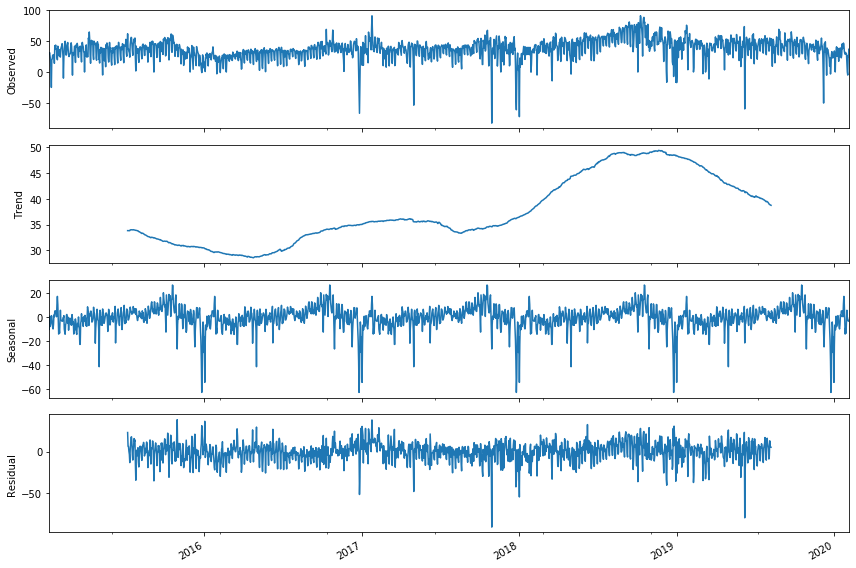

In [0]:
import statsmodels.api as sm

pdf = german_df.loc[german_df['Hour'] == 6, 'Day Ahead Price']

with mpl.rc_context():
  mpl.rc("figure", figsize=(12,8))
  sm.tsa.seasonal_decompose(pdf, freq=365).plot()
  result = sm.tsa.stattools.adfuller(pdf)

#### Autocorrelation of the time series

A very useful way to check seasonality is to see if there is a correlation of the time-series with its lagged version. The lags for which there is high correlation indicate a seasonality with that time-period. This is precisely the information encoded in an autocorrelation function which we will plot now.

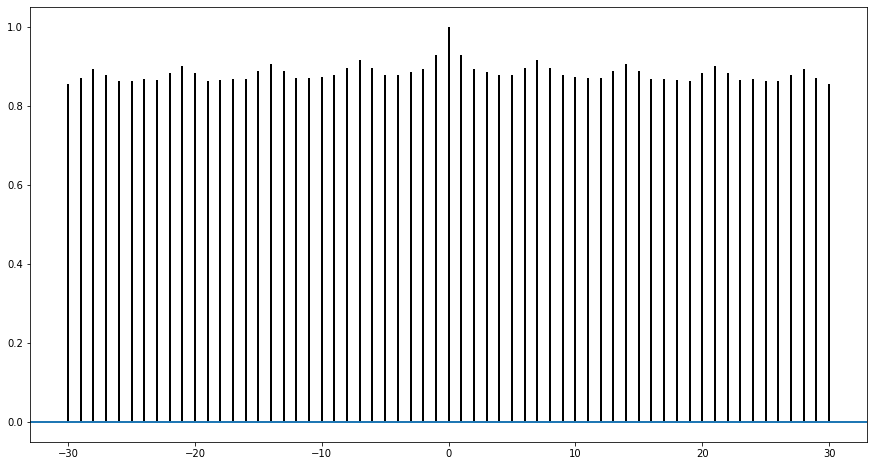

In [0]:
plt.figure(figsize=(15,8))
lags, c, _, _ = plt.acorr(german_df.sort_values(by='Date') \
  .loc[german_df['Hour'] == 5, 'Day Ahead Price'], usevlines=True, normed=True, maxlags=30, lw=2)

The plot above seems to indicate a slight weekly pattern.

In [0]:
ac_df = pd.DataFrame({'lags':lags, 'ac' : c})
highly_ac_list = ac_df.sort_values(by='ac', ascending=False).head(40)['lags'].to_list()
list(filter(lambda x: x>0, highly_ac_list)) # it is symmetric across a change in sign

[1, 7, 14, 21, 8, 6, 2, 28, 15, 13, 3, 22, 20, 4, 5, 9, 27, 10, 12]

#### Fourier space and the spectrum
If you come from a background in physics like I do, you are probably already screaming- why don't you operate on the *fourier space*? Yes, I hear you. Fourier decomposition is great at finding the seasonal and trend patterns in the data. Terms on the lower end of the spectrum (low frequency) can be interpreted as the ones which reveal the trend, while the ones on the higher end can be associated with seasons. It is also quite easy to distinguish the noise by identifying the low amplitude ones (and especially high frequency, low amplitude ones). This gives a very versatile method to deseasonalise/detrend/denoise the data.

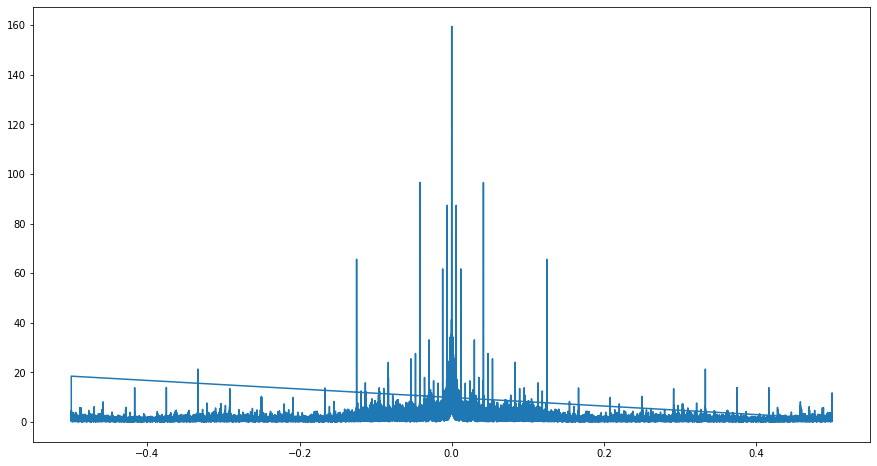

In [0]:
from numpy.fft import fft
from numpy.fft import fftfreq

ft = fft(german_df.sort_values(by='Date').loc[:, 'Day Ahead Price'])
ft_norm = list(map(lambda x: np.sqrt(x.real**2 + x.imag**2)/1000, ft))
freq = fftfreq(len(ft_norm))

plt.figure(figsize=(15,8))
plt.plot(freq[1:], ft_norm[1:])

#### Constructing lagged features

A typical way to incorporate non-local features into our dataset is to consider lagged features. The question then is what lag time should we consider?

### Exogenous series

Until now, we have only considered features extracted from the time-series itself. For the next part, we want to consider exogenous time-series that can be considered in our analysis.

#### Day-ahead load and generation forecasts

Load and generation forecasts are given before the day-ahead prices are set, so they represent important features for estimating the day-ahead price. Further, picking up from ref. [2], it can even be argued that weather data and other features are already considered in this datapoint, so one can even forego considering those in favour of this. This is indeed the approach that I will take, but first it needs a bit of cleaning before it is useful.

##### Generation forecast

In [0]:
root_path = 'energy-prediction/data/Germany/generation-forecast/'
genForecastDF1 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201501010000_201701012359_1.csv'), sep=';')
genForecastDF2 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201701010000_201901012359_1.csv'), sep=';')
genForecastDF3 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201901010000_202101012359_1.csv'), sep=';')

genForecastDF = genForecastDF1 \
  .append(genForecastDF2[genForecastDF2['Date'] != 'Jan 1, 2017']) \
  .append(genForecastDF3[genForecastDF3['Date'] != 'Jan 1, 2019'])

genForecastDF['Date'] = pd.to_datetime(genForecastDF['Date'])
genForecastDF['Time of day'] = pd.to_datetime(genForecastDF['Time of day']).dt.time
genForecastDF.replace('-', 'NaN', inplace=True)
for column in list(filter(lambda x: x.endswith('[MWh]'), genForecastDF.columns)):
  genForecastDF[column] = genForecastDF[column].apply(lambda x: float(x.replace(',', '')))

genForecastDF['timedate'] = pd.to_datetime(genForecastDF['Date'].astype('str') + ' ' + genForecastDF['Time of day'].astype('str'))
genForecastDF.set_index('timedate', drop=True, inplace=True)
genForecastDF.index.name = None

genForecastDF.sort_index(inplace=True) # so that accessing by key is possible

# correct for daylight savings time
change_dict = {}
for d1, d2 in daylight_savings_ranges:
  previous_index = (genForecastDF.loc[d1:d2, 'Time of day'].index)
  modified_index = previous_index - pd.to_timedelta(1, unit='h')
  change_dict.update(zip(previous_index, modified_index))

corrected_genForecastDF = genForecastDF.rename(index=change_dict)
new_index = corrected_genForecastDF.index \
  .where(~corrected_genForecastDF.index.duplicated(), corrected_genForecastDF.index + pd.to_timedelta(1, unit='h'))
corrected_genForecastDF.set_index(new_index, inplace=True)
corrected_genForecastDF['Time of day'] = corrected_genForecastDF.index.time
corrected_genForecastDF['Date'] = pd.to_datetime(corrected_genForecastDF.index.date)

# add a column to indicate this change
corrected_genForecastDF['Daylight Savings Time'] = 0
corrected_genForecastDF.loc[change_dict.values(), 'Daylight Savings Time'] = 1

corrected_genForecastDF.sample(5)

,Date,Time of day,Total[MWh],Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],Other[MWh],Daylight Savings Time
2017-01-24 13:15:00,2017-01-24,13:15:00,NaN,53.0,205.0,1017.0,NaN,0
2016-06-23 18:00:00,2016-06-23,18:00:00,67747.0,191.0,1163.0,1174.0,58789.0,1
2017-02-02 13:15:00,2017-02-02,13:15:00,NaN,535.0,1207.0,1855.0,NaN,0
2016-01-13 03:15:00,2016-01-13,03:15:00,NaN,447.0,3102.0,0.0,NaN,0
2018-07-01 23:00:00,2018-07-01,23:00:00,53811.0,329.5,2727.0,0.0,41899.5,1


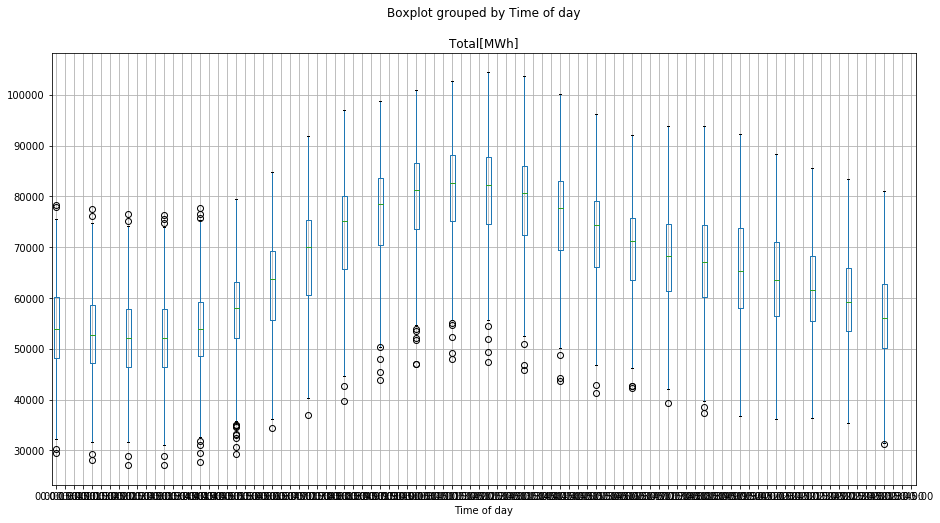

In [0]:
corrected_genForecastDF.boxplot('Total[MWh]', by='Time of day', figsize=(15,8))

##### Load forecast

In [0]:
root_path = 'energy-prediction/data/Germany/load-forecast/'
loadForecastDF1 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201501010000_201701012345_1.csv'), sep=';')
loadForecastDF2 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201701010000_201901012345_1.csv'), sep=';')
loadForecastDF3 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201901010000_202002082345_1.csv'), sep=';')
loadForecastDF = loadForecastDF1 \
  .append(loadForecastDF2[loadForecastDF2['Date'] != 'Jan 1, 2017']) \
  .append(loadForecastDF3[loadForecastDF3['Date'] != 'Jan 1, 2019'])

loadForecastDF['Date'] = pd.to_datetime(loadForecastDF['Date'])
loadForecastDF['Time of day'] = pd.to_datetime(loadForecastDF['Time of day']).dt.time
loadForecastDF.replace('-', 'NaN', inplace=True)
for column in list(filter(lambda x: x.endswith('[MWh]'), loadForecastDF.columns)):
  loadForecastDF[column] = loadForecastDF[column].apply(lambda x: float(x.replace(',', '')))

# set key to datetime
loadForecastDF['timedate'] = pd.to_datetime(loadForecastDF['Date'] \
                                .astype('str') + ' ' + loadForecastDF['Time of day'].astype('str'))
loadForecastDF.set_index('timedate', drop=True, inplace=True)
loadForecastDF.index.name = None

loadForecastDF.sort_index(inplace=True) # so that accessing by key is possible

# correct for daylight savings time
change_dict = {}
for d1, d2 in daylight_savings_ranges:
  previous_index = (loadForecastDF.loc[d1:d2, 'Time of day'].index)
  modified_index = previous_index - pd.to_timedelta(1, unit='h')
  change_dict.update(zip(previous_index, modified_index))

corrected_loadForecastDF = loadForecastDF.rename(index=change_dict)
new_index = corrected_loadForecastDF.index \
  .where(~corrected_loadForecastDF.index.duplicated(), corrected_loadForecastDF.index + pd.to_timedelta(1, unit='h'))
corrected_loadForecastDF.set_index(new_index, inplace=True)
corrected_loadForecastDF['Time of day'] = corrected_loadForecastDF.index.time
corrected_loadForecastDF['Date'] = pd.to_datetime(corrected_loadForecastDF.index.date)

# add a column to indicate this change
corrected_loadForecastDF['Daylight Savings Time'] = 0
corrected_loadForecastDF.loc[change_dict.values(), 'Daylight Savings Time'] = 1

corrected_loadForecastDF.sample(5)

,Date,Time of day,Total[MWh],Daylight Savings Time
2019-12-15 18:45:00,2019-12-15,18:45:00,14959.00,0
2017-06-17 03:15:00,2017-06-17,03:15:00,10290.50,1
2020-01-22 20:00:00,2020-01-22,20:00:00,16805.00,0
2016-11-05 19:15:00,2016-11-05,19:15:00,14339.75,0
2019-03-10 13:15:00,2019-03-10,13:15:00,12983.75,0


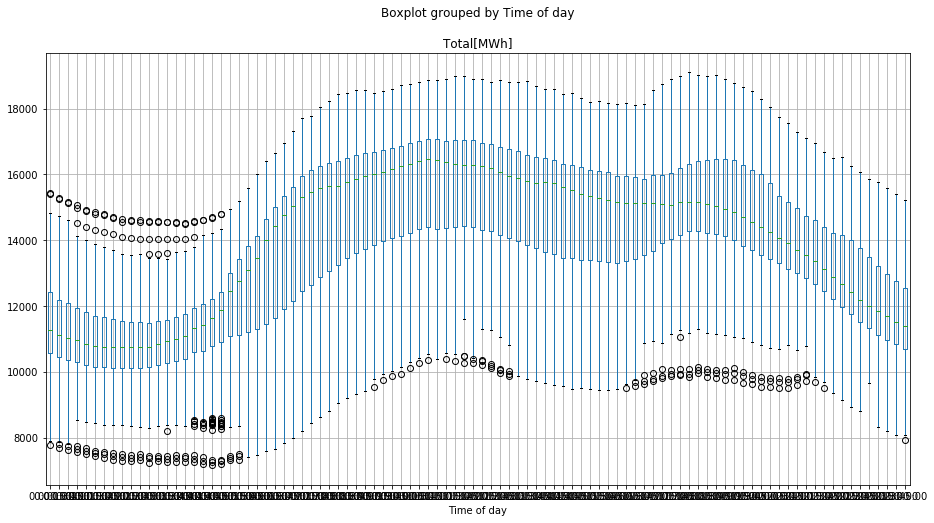

In [0]:
corrected_loadForecastDF.boxplot('Total[MWh]', by='Time of day', figsize=(15,8))

In [0]:
corrected_loadForecastDF[corrected_loadForecastDF['Total[MWh]'].isna()]

,Date,Time of day,Total[MWh],Daylight Savings Time
2015-09-25 23:00:00,2015-09-25,23:00:00,NaN,1
2015-09-25 23:15:00,2015-09-25,23:15:00,NaN,1
2015-09-25 23:30:00,2015-09-25,23:30:00,NaN,1
2015-09-25 23:45:00,2015-09-25,23:45:00,NaN,1
2015-09-26 00:00:00,2015-09-26,00:00:00,NaN,1
...,...,...,...,...
2020-01-31 22:45:00,2020-01-31,22:45:00,NaN,0
2020-01-31 23:00:00,2020-01-31,23:00:00,NaN,0
2020-01-31 23:15:00,2020-01-31,23:15:00,NaN,0
2020-01-31 23:30:00,2020-01-31,23:30:00,NaN,0


##### Combining the datasets

We want to join these datasets to the `german_df` that we have. But note that it has a different resolution from the price dataset: the load and generation forecast are given for every 15 minutes, while the prices are given hourly. For simplicity and a lack of better idea, I will just take the hourly average for the load and generation forecast.

In [0]:
groupedLoad = corrected_loadForecastDF \
  .groupby([corrected_loadForecastDF.index.date, corrected_loadForecastDF.index.hour])
load_to_joinDF = groupedLoad.agg({
    'Total[MWh]' : 'mean',
    'Date' : 'min',
    'Time of day' : 'min'
})

load_to_joinDF['timedate'] = pd.to_datetime(load_to_joinDF['Date'] \
                                            .astype('str') + ' ' + load_to_joinDF['Time of day'].astype('str'))
load_to_joinDF.set_index('timedate', drop=True, inplace=True)
load_to_joinDF.index.name = None

groupedGen = corrected_genForecastDF \
  .groupby([corrected_genForecastDF.index.date, corrected_genForecastDF.index.hour])
gen_to_joinDF = groupedGen.agg({
    'Total[MWh]' : 'mean',
    'Wind offshore[MWh]' : 'mean',
    'Wind onshore[MWh]' : 'mean',
    'Photovoltaics[MWh]' : 'mean',
    'Other[MWh]' : 'mean',
    'Date' : 'min',
    'Time of day' : 'min'
})

gen_to_joinDF['timedate'] = pd.to_datetime(gen_to_joinDF['Date'] \
                                           .astype('str') + ' ' + gen_to_joinDF['Time of day'].astype('str'))
gen_to_joinDF.set_index('timedate', drop=True, inplace=True)
gen_to_joinDF.index.name = None

In [0]:
load_to_joinDF.rename(columns={'Total[MWh]' : 'Total Load'}, inplace=True)
power_sources = list(filter(lambda x: x.endswith('[MWh]'), sorted(gen_to_joinDF)))
renamed_power_sources = list(map(lambda x: x[:-5] + ' Generation', power_sources))

gen_to_joinDF.rename(columns=dict(zip(power_sources, renamed_power_sources)), inplace=True)

In [0]:
# does an inner join
columns_for_join = {
    'load' : 'Total Load',
    'gen' : renamed_power_sources
}
german_df_with_load = german_df \
  .join(load_to_joinDF[columns_for_join['load']])
german_df_with_load_and_gen = german_df_with_load. \
  join(gen_to_joinDF[columns_for_join['gen']])

In [0]:
german_df_with_load_and_gen.sample(5)

,Date,Time of day,Daylight Savings Time,Day Ahead Price,Bidding Zone,Hour,Day of Week,Day,Month,Year,DE-TH,DE-ST,DE-BY,DE-NW,DE-SH,DE-RP,DE-SN,DE,DE-BW,DE-HB,DE-BB,DE-NI,DE-SL,AT,DE-BE,LU,DE-HE,DE-MV,DE-HH,Total Load,Other Generation,Photovoltaics Generation,Total Generation,Wind offshore Generation,Wind onshore Generation
2019-04-18 10:00:00,2019-04-18,10:00:00,1,40.39,DE-LU,10.0,3,18,4,2019,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,16116.5000,53027.5,7047.50,93399.0,855.7500,2189.625
2017-08-02 23:00:00,2017-08-02,23:00:00,1,28.10,DE-AT-LU,23.0,2,2,8,2017,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,11212.1250,44329.0,0.00,51175.0,529.5000,1182.000
2015-10-01 03:00:00,2015-10-01,03:00:00,1,29.40,DE-AT-LU,3.0,3,1,10,2015,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,10961.0000,NaN,0.00,NaN,25.9375,854.250
2017-08-05 06:00:00,2017-08-05,06:00:00,1,27.68,DE-AT-LU,6.0,5,5,8,2017,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,11244.8750,41979.0,732.25,53034.0,409.5000,1622.250
2017-02-14 21:00:00,2017-02-14,21:00:00,0,42.26,DE-AT-LU,21.0,1,14,2,2017,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,15732.3125,64035.0,0.00,72873.0,350.7500,1859.250


**Correlation** with prices

### How do neighbouring markets affect the price?

The importance of accounting for neighbouring market prices is well described in ref. [2].

Part 2 of **time forecasting with energy**

## Predictive models

This part will be technical, but fun. The purpose is to explore SOTA models for time-series forecasting, and their applicability to day-ahead price forecasting. In a typical use-case, we have access to a history of recorded day-ahead prices, and we are interested in forecasting the day-ahead prices in an interval consisting of a tuple of 24 prices for each day. The problem can be formulated precisely as follows.
>  Let $\{t_1, t_2, t_3, ...\} := \mathfrak{T}$ represent a collection of dates in  chronological order, $p_t \in \mathbb{R}^{24}$ be the day-ahead price indexed by $t \in \mathfrak{T}$. Given some historic day-ahead prices $p_{t_1}, p_{t_2}, ... ,p_{t_k}$, forecast the future day-ahead prices $p_{t_{k+1}}, ..., p_{t_{k+h}}$ in a certain window-size of $h \in \mathbb{Z}$. In addition, we have a collection of exogenous time series- $d_{t_1},d_{t_2}, ..., d_{t_k}$, which includes the generation and consumption forecasts and the holiday list.

Before proceeding to investigate our models, it is important to figure out a cross-validation strategy and the testing strategy using a metric to assess the performance of each of our models. So, let us briefly touch upon these topics first.  

1. The cross-validation strategy for temporal data is a bit different from randomly choosing a subset of the dataset. Since the goal of our analysis is to forecast future values using present data, we will likewise train on a dataset from the past, and validate it against a subset to the future of it. This simulates the actual situation at hand; see [3, 4] for more details.
2. As for the metric we choose to analyze the performance of each model, the assessment is usually done with the *Diebold-Mariano* test.$^{[2]}$ We will analyze the errors plotted over time intervals, while using sMAPE as a primary indicator of performance. This should be sufficient for a first-estimate of how well our models are doing; later on- in the next section- we will look at where exactly each model is performing badly, and try to see if there is an overlap in this regard.

In [0]:
def extractHourlyData(df, data_columns, hour_column='Hour', date_column='Date'):
  num_of_sample = len(df['Date'].unique())
  num_of_data_columns = len(data_columns)
  hourly_data = np.zeros((num_of_sample, 24*num_of_data_columns))
  for i, data_column in enumerate(data_columns):
    for d in range(24):
      hourly_data[:, i*24 + d] = df[df[hour_column] == d].sort_values(by=date_column).loc[:, data_column]
  return hourly_data

In [0]:
from math import fabs

def test_train_timesplit(df, date_column_name='Date', train_size=0.9, test_size=0.1):
  """
    Returns test-train split data based on date with test chronologically later than train data.
  """
  min_date = df[date_column_name].min()
  max_date = df[date_column_name].max()
  train_split_date = min_date + (train_size*(max_date - min_date))
  test_split_date = train_split_date + (test_size*(max_date - min_date))
  train_df = df[df[date_column_name] < train_split_date]
  test_df = df[(df[date_column_name] > train_split_date) & (df[date_column_name] < test_split_date)]
  return train_df, test_df

def day_forward_chaining(df, date_column_name='Date', k=10):
  for i in range(k):
    yield test_train_timesplit(df, date_column_name, train_size=(i/k), test_size=(1/k))

# Example use-case:
# for train_df, test_df in day_forward_chaining(german_df, date_column_name='Date', k=40):
#   <<< do your model training and stuff here >>>

@jit
def compute_error_sequences(y_true, y_pred):
  return (y_pred - y_true)

@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = fabs(a) + fabs(b)
        if c == 0:
            continue
        out += fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

### Basic benchmarks

Deep learning models can be somewhat of a blackbox, so to make sure that they are infact improving on our estimates: it is better to have a estimate of baseline performance that we can expect proceeding naively. The purpose of this is as follows: deep learning and gradient boosting are powerful algorithms that can significantly increase the forecasting accuracies, given that one does proper tuning and large-enough datasets. On the other hand, hyperparameter estimation is extremely important in getting the most of these models. In order to not fly blind, we would like to establish what the accuracies of simple statistical models are (as you will see, some will turn out to be not that simple) so we know what accuracies are a good improvement over standard forecasting techniques.

Naive forecasting? This is as simple as it gets with time-series forecasting; one just takes $\hat{y}_t = y_{t-1}$.

In [0]:
for h in range(24):
  yhat = german_df.loc[german_df['Hour'] == h, 'Day Ahead Price'].shift().to_numpy()
  y = german_df.loc[german_df['Hour'] == h, 'Day Ahead Price'].to_numpy()

smape_fast(y[1:], yhat[1:])

28.29964703834496

#### Regression techniques

Fit daily price to a bigaussian separately for each type of day?

In [0]:
from sklearn.mixture import GaussianMixture

simpleModel = GaussianMixture(n_components=2)

##### Dynamic Harmonic regression

Time series data are better represented using Fourier terms.

### Exponential smoothing (ES) and Holtz-Winter model

Traditional techniques, such as simple exponential smoothing and related techniques may be simple, but they ...
$$y_t = y_{t-1} + \alpha (y_{t-1} - \hat{y}_{t-1})$$

In [0]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

$$y_{t+h} = l_t +h b_t + s_{t+h-m(k+1)}$$
$$l_t = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(l_{t-1} + b_{t-1})$$
$$b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*)b_{t-1}$$
$$s_t = \gamma \frac{y_t}{(l_{t-1} + b_{t-1})} + (1-\gamma)s_{t-m}$$

### Auto-regressive Integrated Moving Average (ARIMA)

The technique here is simple: use regression over lagged features. The specific lagged features that we use depends on seasonality: from the autocorrelation function and fourier analysis- we should be considering ??

> **A note on stationarity**: 

### Quantile regression forest

### Prophet

Prophet is a forecasting package created by **Facebook** for their internal forecasting demands. The key advantage of `Prophet` is that it is supposed to work as is without a lot of preparation.

In [0]:
from fbprophet import Prophet

german_df_for_prophet = german_df[['Day Ahead Price', 'Date']].copy()
german_df_for_prophet = german_df_for_prophet.rename(columns={'Day Ahead Price' : 'y', 'Date' : 'ds'})
german_df_for_prophet['ds'] = german_df_for_prophet.index.to_series()

PmodelA = Prophet()
PmodelA.fit(german_df_for_prophet)

Part 3 of **time forecasting with energy**

## Trees and Gradient Boosting



In [0]:
import xgboost

Should we be using the fourier transforms somehow?

Show we allow some ML-style algorithm to figure out which parts of the fourier series to use?

In [0]:
import lightgbm

Part 4 of **time forecasting with energy**

## Deep Learning Models

Deep learning has shown promising results in many areas of machine learning problems, and it is natural to wonder if it can have any significant impact in the time-series forecasting arena. In the image and NLP domains, convNets and LSTMs reign supreme, and the question is- what is the relevant architecture for a SOTA time-series prediction?


In [0]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

TensorFlow 2.x selected.


##### Some preprocessing for deep models

Neural networks are highly scale-sensitive, so we need to rescale it.

In [0]:
# NNs are sensitive to range, so rescale
mean = german_df_with_load_and_gen['Day Ahead Price'].mean()
var = german_df_with_load_and_gen['Day Ahead Price'].var()
german_df_with_load_and_gen['Day Ahead Price (rescaled)'] = (german_df_with_load_and_gen['Day Ahead Price'] - mean) / var

mean = german_df_with_load_and_gen['Total Load'].mean()
var = german_df_with_load_and_gen['Total Load'].var()
german_df_with_load_and_gen['Total Load (rescaled)'] = (german_df_with_load_and_gen['Total Load'] - mean) / var

mean = german_df_with_load_and_gen['Total Generation'].mean()
var = german_df_with_load_and_gen['Total Generation'].var()
german_df_with_load_and_gen['Total Generation (rescaled)'] = (german_df_with_load_and_gen['Total Generation'] - mean) / var

We have a few categorical variables in our data: deep models will need them to be one-hot encoded for use.

In [0]:
ohe_holiday_df = pd.get_dummies(german_df_with_load_and_gen[['DE', 'LU']])
ohe_bidding_zones_df = pd.get_dummies(german_df_with_load_and_gen['Bidding Zone'])

proc_german_df = pd.concat([german_df_with_load_and_gen, ohe_bidding_zones_df], axis=1)
proc_german_df2 = pd.concat([proc_german_df, ohe_holiday_df], axis=1)

Finally, we split the dataset into a a training and validation set.

In [0]:
train_df, val_df = test_train_timesplit(proc_german_df2, train_size=0.9, test_size=0.1)

In [0]:
window_size = 8
batch_size = 16

# convert each hour to multi-sequential form
price_train_X_data = extractHourlyData(train_df, ['Day Ahead Price (rescaled)', 'Day of Week'] + sorted(ohe_bidding_zones_df) + sorted(ohe_holiday_df))
price_train_y_data = extractHourlyData(train_df, ['Day Ahead Price (rescaled)'])
price_val_X_data = extractHourlyData(val_df, ['Day Ahead Price (rescaled)', 'Day of Week'] + sorted(ohe_bidding_zones_df) + sorted(ohe_holiday_df))
price_val_y_data = extractHourlyData(val_df, ['Day Ahead Price (rescaled)'])

# generate windowed datasets
generator = TimeseriesGenerator(
    price_train_X_data, 
    price_train_y_data, 
    length = window_size, 
    sampling_rate = 1,
    batch_size = batch_size)

val_generator = TimeseriesGenerator(
    price_val_X_data, 
    price_val_y_data, 
    length = window_size, 
    sampling_rate = 1,
    batch_size = batch_size)

The simplest deep model that we can come up with is a feed-forward neural network that takes into account the time and date of the price, and the bidding zone. This does not take into account the recent history of the prices, hence not capable of noticing local trends in the price based on the previous day prices.

In [0]:
X_train = train_df[[
                    'Day', 
                    'Month', 
                    'Year', 
                    'Hour', 
                    'Day of Week', 
                    'Daylight Savings Time'] \
                      + sorted(ohe_bidding_zones_df) + sorted(ohe_holiday_df)].to_numpy()
y_train = train_df['Day Ahead Price (rescaled)'].to_numpy()

# define model
ffmodelA = Sequential()
ffmodelA.add(Dense(80))
ffmodelA.add(Dense(30))
ffmodelA.add(Dense(1))

# train the model
ffmodelA.compile(loss='mae', optimizer='Adam')
ffmodelA.fit(X_train, y_train, epochs=50, validation_split=0.01, verbose=0)

In [0]:
X_test = val_df[[
                'Day', 
                'Month', 
                'Year', 
                'Hour', 
                'Day of Week',
                'Daylight Savings Time'] \
                  + sorted(ohe_bidding_zones_df) + sorted(ohe_holiday_df)].to_numpy()
y_val = val_df['Day Ahead Price (rescaled)'].to_numpy()
y_pred = ffmodelA.predict(X_test)
smape_fast(y_val.flatten(), y_pred.flatten())

127.50747759738957

#### RNN, LSTM and all those vanilla sequential NNs

First up, let's see how the basic sequential neural networks perform so a benchmark can be established for deep learning algorithms. I will consider RNNs, LSTMs and GRUs. `Keras` makes this a relatively easy task these days.

RNN is the most basic sequential NN. One obvious short-coming is that it only takes into account the previous few terms in the sequence; so weekly, monthly and annual patterns are probably not accounted for by this model. But enough of speculations- it's time to see how it actually does.

In [0]:
rmodelA = Sequential()
rmodelA.add(SimpleRNN(100, return_sequences=True))
rmodelA.add(SimpleRNN(100, return_sequences=True))
rmodelA.add(SimpleRNN(100, return_sequences=True))
rmodelA.add(SimpleRNN(24))

rmodelA.compile(loss='mae', optimizer='Adam')
rmodelA_history = rmodelA.fit(generator, validation_data=val_generator, epochs=100, verbose=0)

plt.figure(figsize=(15,8))
plt.plot(rmodelA_history.history['loss'])
plt.plot(rmodelA_history.history['val_loss'])

  ...
    to  
  ['...']


In [0]:
y_val, y_pred = np.zeros(0), np.zeros(0)

for X_val_p, y_val_p in val_generator:
  y_val = np.append(y_val, y_val_p)
  y_pred = np.append(y_pred, rmodelA.predict(X_val_p))

print(smape_fast(y_pred.flatten(), y_val.flatten()))

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

rmodelA_df = pd.DataFrame({
    'predicted' : y_pred.flatten(), 
    'actual' : y_val.flatten()
})
rmodelA_df.loc[100:200,:].plot.line(y='predicted', color='red', ax=axes, marker='*')
rmodelA_df.loc[100:200,:].plot.line(y='actual', color='grey', ax=axes, marker='o')

RNNs with memory are probably better suited for sequences with long time-periods, so let's try LSTMs and GRUs.

In [0]:
rmodelB = Sequential()
rmodelB.add(GRU(100, dropout=0.3, return_sequences=True))
rmodelB.add(BatchNormalization())
rmodelB.add(GRU(100, dropout=0.3, return_sequences=True))
rmodelB.add(BatchNormalization())
rmodelB.add(GRU(50, dropout=0.2, return_sequences=True))
rmodelB.add(BatchNormalization())
rmodelB.add(GRU(24))

rmodelB.compile(loss='mae', optimizer='Adam')

rmodelB_history = rmodelB.fit(generator, validation_data=val_generator, epochs=100, verbose=0)

plt.figure(figsize=(15,8))
plt.plot(rmodelB_history.history['loss'])
plt.plot(rmodelB_history.history['val_loss'])

In [0]:
y_val, y_pred = np.zeros(0), np.zeros(0)

for X_val_p, y_val_p in val_generator:
  y_val = np.append(y_val, y_val_p)
  y_pred = np.append(y_pred, rmodelB.predict(X_val_p))

print(smape_fast(y_pred.flatten(), y_val.flatten()))

In [0]:
rmodelC = Sequential()
rmodelC.add(LSTM(100, dropout=0.3, return_sequences=True))
rmodelC.add(BatchNormalization())
rmodelC.add(LSTM(100, dropout=0.3, return_sequences=True))
rmodelC.add(BatchNormalization())
rmodelC.add(LSTM(100, dropout=0.3, return_sequences=True))
rmodelC.add(BatchNormalization())
rmodelC.add(LSTM(24))

rmodelC.compile(loss='mae', optimizer='Adam')

rmodelC_history = rmodelC.fit(generator, validation_data=val_generator, epochs=100, verbose=0)

plt.figure(figsize=(15,8))
plt.plot(rmodelC_history.history['loss'])
plt.plot(rmodelC_history.history['val_loss'])

NameError: ignored

In [0]:
y_val, y_pred = np.zeros(0), np.zeros(0)

for X_val_p, y_val_p in val_generator:
  y_val = np.append(y_val, y_val_p)
  y_pred = np.append(y_pred, rmodelC.predict(X_val_p))

print(smape_fast(y_pred.flatten(), y_val.flatten()))

113.66723801668165


An even better model for forecasting is supposed to be the **Convolutional bi-LSTM**. Here the convolutional layers at the bottom extract relevent local features before passing it onto an LSTM.

#### InceptionTime
InceptionNet is one of the SOTA models in image classification, which uses a very wide CNN with the help of depthwise 1D-convolution to improve the accuracy of the model.
> the use of convNets in 1D a la Inception, coupled with ensembling- InceptionTime.

#### Hybrid ES-RNN approach

This is an approach by Uber, which has seen promising results for forecasting demand for their services across time, and as such- the issues they face are rather similar to the one we have on our hands, so let us see how it performs in our case.

https://eng.uber.com/m4-forecasting-competition/  
https://eng.uber.com/neural-networks/  

Implementing dynamic computation graphs in tensorflow:
https://github.com/tensorflow/fold/blob/master/tensorflow_fold/g3doc/blocks.md

#### LSTM-MSNet approach

The SOTA approach for multi-seasonal sequences is supposed to be the LSTM-MSNet model. The idea here is quite simple; deseasonalise the time-series, then feed into a deep neural network, and then seasonalise it again.

### Gluon TS

In [0]:
import gluonts

Part 5 of **time forecasting with energy**

## Analysis and discussion

Where do the errors lie? Residual histograms and ACF

Combine our models with XGBoost?

Part 6 of **time forecasting with energy**

## Deployment of the models

Finally, we have a few working models that perform decently. To make it more useful, we would like any third party to be able to view the forecasts.

In [0]:
API_KEY = '2982813f-cafd-471c-8cf4-108ec8e7c4d2'

In [0]:
from entsoe import EntsoePandasClient
import pandas as pd

client = EntsoePandasClient(api_key=API_KEY)
start = pd.Timestamp('20200301', tz='Europe/Brussels')
end = pd.Timestamp('20200302', tz='Europe/Brussels')
bidding_zone = 'DE-LU'
country_code = 'DE-LU'

# methods that return Pandas Series
# current_df = client.query_day_ahead_prices(country_code, start=start, end=end)
# client.query_load(country_code, start=start, end=end)
# client.query_load_forecast(country_code, start=start, end=end)
client.query_generation_forecast(country_code, start=start, end=end)

2020-03-01 00:00:00+01:00    35424.0
2020-03-01 01:00:00+01:00    34959.0
2020-03-01 02:00:00+01:00    34605.0
2020-03-01 03:00:00+01:00    34751.0
2020-03-01 04:00:00+01:00    35145.0
2020-03-01 05:00:00+01:00    35079.0
2020-03-01 06:00:00+01:00    35282.0
2020-03-01 07:00:00+01:00    36049.0
2020-03-01 08:00:00+01:00    39394.0
2020-03-01 09:00:00+01:00    43996.0
2020-03-01 10:00:00+01:00    48158.0
2020-03-01 11:00:00+01:00    50576.0
2020-03-01 12:00:00+01:00    50433.0
2020-03-01 13:00:00+01:00    48854.0
2020-03-01 14:00:00+01:00    45553.0
2020-03-01 15:00:00+01:00    41024.0
2020-03-01 16:00:00+01:00    35138.0
2020-03-01 17:00:00+01:00    33681.0
2020-03-01 18:00:00+01:00    37203.0
2020-03-01 19:00:00+01:00    38916.0
2020-03-01 20:00:00+01:00    38981.0
2020-03-01 21:00:00+01:00    36836.0
2020-03-01 22:00:00+01:00    36452.0
2020-03-01 23:00:00+01:00    35102.0
dtype: float64

In [0]:
current_df

References.  
**A**  
[1] Electricity storage is not possible efficiently at a large scale for now, but there are some interesting ideas out there for sure. For example, see flywheels: https://www.youtube.com/watch?v=7K4W4hA6aV4.

[2] J. Lago, F. D. Ridder, P. Vrancx, B. D. Schutter, *Forecasting day-ahead electricity prices in Europe: the importance of considering market integration*, Applied Energy 211 (2018) 890-903.

[3] https://www.smard.de/en/topic-article/5870/9846   

**B**  
[1] R. J. Hyndman, and G. Athanasopoulos, Forecasting: Principles and Practice, https://otexts.com/fpp2/index.html  

**C**  
[1] J. Lago, F. D. Ridder, B. D. Schutter, *Forecasting spot electricity prices: Deep learning approaches and empirical comparison of traditional algorithms*, doi:https://doi.org/10.1016/j.apenergy.2018.02.069 (2017).

[2] A. Alexandrov et al, *GluonTS: Probabilistic Time Series Models in Python*, https://arxiv.org/pdf/1906.05264v2.pdf (2019).

[3] L. J. Tashman, *Out-of-sample tests of forecasting accuracy: an analysis and review*, International Journal of Forecasting, 2000, vol. 16, issue 4, 437-450 [https://econpapers.repec.org/article/eeeintfor/v_3a16_3ay_3a2000_3ai_3a4_3ap_3a437-450.htm].

[4] More on the different approaches to the validation strategies for a time series here: https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

[?] R. J. Hyndman, E. Wang, N. Laptev, *Large-Scale Unusual Time Series Detection*,  [https://robjhyndman.com/papers/icdm2015.pdf]

[?] https://eng.uber.com/neural-networks/

[?] K. Bandara, C. Bergmeir, H. Hewamalage, *LSTM-MSNet: Leveraging Forecasts on Sets of
Related Time Series with Multiple Seasonal Patterns* arXiv:1909.04293, Sep. (2019). [https://arxiv.org/pdf/1909.04293.pdf]